## Cellular Automata Model for Traffic

Layout of CA:

- Each section of each lane is a cell

Model assumptions:
- .3 miles between 14th and Peachtree to 10th and Peachtree travelling southbound (google maps)
- Average car is 16ft long (https://www.quora.com/What-is-the-average-length-of-a-car-in-feet)
- typically space of a car between each car, so each cell is 16ft * 2 = 32 ft long
- .3 miles = 1584 ft
- 1584 ft / 32 ft = 49.5 cells, round up to 50
- 2 lane road
- road model is therefore (50 x 2)


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [2]:
unoccupied = 0
occupied = 1

ROAD_SIZE = (50, 2)

def init_road_vels():
    R = np.zeros(ROAD_SIZE)
    V = np.full(ROAD_SIZE, -1)
    
    return R, V

def show_road(R, time_no):
    args = {}
    args['cmap'] = 'jet'
    args['vmin'] = 0
    args['vmax'] = 1
    plt.figure(figsize=(8, 8))
    plt.matshow(R, fignum=1, **args)
    plt.xlabel('lanes')
    plt.ylabel('Peachtree southbound')
    # plt.colorbar()
    
    plt.title("Road at time {}".format(time_no))
    pass

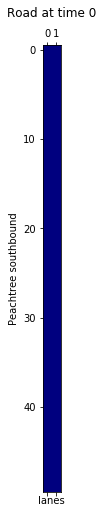

In [3]:
R = np.zeros(ROAD_SIZE)

show_road(R, 0)

### Velocities

We'll keep track of velocities in a similarly shaped array. 

- A velocitiy of -1 means unoccupied
- A velocity > -1 represents how many squares this car will travel in a timestep 


We'll use timesteps $t$ = 1 sec. For a car going 50mph = 73.33fps = 2.3 cells / t. Since we need integers we'll round this down to 2 cells / t (~43.6 mph)

In [4]:
V = np.full(ROAD_SIZE, -1)

### Movement 

We'll model movement stochastically. Each car has a probability of going straight, left or right.

For now, these probabilites are as follows. They'll later be empirically validated with the NGSIM data.

- P(straight) = .8
- P(left) = .1
- P(right) = .1

In [5]:
def get_rand_dir():
    r = random.random()
    
    # right
    if r > .9:
        return 1
    
    # left
    if r > .8:
        return -1

    # straight
    return 0

In [6]:
def step(R, V):
    R_new = np.zeros(R.shape)
    V_new = np.full(V.shape, -1)
    no_cars_leaving = 0
    
    cars = (R == 1)
    
    # go backwards since cars moving forward
    for i in range(R.shape[0] -1, -1, -1):
        for j in range(R.shape[1]):    
            if cars[i, j]:
                # print("there's a car in {}, {}".format(i, j))
                d = get_rand_dir()
                
                new_lane = j + d
                
                # don't actually change lane if on edge
                if new_lane > 1 or new_lane < 0:
                    new_lane -= d
                
                new_block = i + V[i, j]
                
                if new_block >= R.shape[0]:
                    print('Car left road')
                    no_cars_leaving += 1
                    new_block = None
                else:
                    # make sure not occupied
                    while R_new[new_block, new_lane] and new_block > i:
                        new_block -= 1
                
                # couldnt move
                if new_block == i:
                    new_block = i
                    new_lane = j
                
                if new_block:
                    R_new[new_block, new_lane] = 1
                    V_new[new_block, new_lane] = V[i, j]
        
    return R_new, V_new, no_cars_leaving
    

In [11]:
R, V = init_road_vels()
R[0, 0] = 1
V[0, 0] = 1

### Run basic sim

In [7]:
R, V = init_road_vels()
R[0, 0] = 1
R[0, 1] = 1
V[0, 0] = 2
V[0, 1] = 2


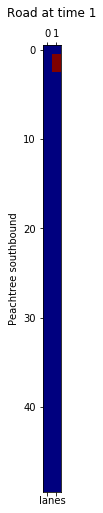

In [8]:
R, V, _ = step(R, V)
show_road(R, 1)

In [11]:
def run_sim():
    T_MAX = 100
    R, V = init_road_vels()
    R[0, 0] = 1
    R[0, 1] = 1
    V[0, 0] = 2
    V[0, 1] = 2
    times = []
    for t in range(T_MAX):
        num = 0
        R, V, num = step(R, V)
        
        if num > 0:
            l = [t] * num
            times.extend(l)
    
    print("Cars exited road at times: ", times)
    print("On average, took a car {} seconds to get through road.".format(np.average(times)))

    show_road(R, t)

Car left road
Car left road
Cars exited road at times:  [24, 25]
On average, took a car 24.5 seconds to get through road.


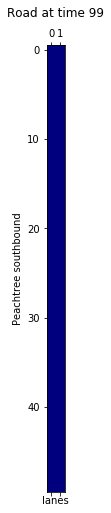

In [16]:
run_sim()

## TODO's to expand model 

- Get distributions for car entering road rather than hard coded. This will allow more cars to populate road over time and different levels of traffic
- map time step, $t$, to an actual time amount
- map velocities to real speeds
- run with different configurations (starting points with cars)
- add stop lights and cars entering road